# 1 Fetching Data

In [1]:
import numpy as np
import pandas as pd
import concurrent.futures
import requests
import time
from functools import partial
from datetime import datetime
import os

In [2]:
def toDatetime(record):
    """
    Convert formatted date-time text into timestamp. 
    
    Example: datetime.strptime('2019-08-09 01:01:01', "%Y-%m-%d %H:%M:%S")
             results: ==>    datetime.datetime(2019, 8, 9, 1, 1, 1)
    """
    timestamp = record['timestamp']
    record['timestamp'] = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S")
    return record


In [3]:
def getData(startTime, endTime , freq="Daily"):
    """
    Convert formatted date-time text into timestamp.
    This is specifically tailored to the source of data we use here
    
    Keyword arguments:
    startTime -- the starting date of the period you wish to fetch (YYYY-MM-DD)
    endTime -- the ending date of the period you wish to fetch (YYYY-MM-DD)
    freq -- the frequency of data (Hourly/Daily/...)
    """
    reportingGroups = ["Electricity"]
    locationsLink = 'https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List'
    locationsRequest = requests.get(locationsLink) # initialize api
    locationsRequest.raise_for_status() # get data from api
    locations = pd.DataFrame.from_dict(locationsRequest.json())
    locations = locations['locationName']
    data = []
    dataLink = (f"https://helsinki-openapi.nuuka.cloud/api/v1.0/"
                f"EnergyData/{freq}/ListByProperty")
    
    # Helper function for concurrency 
    def request(group, location):
        payload = {'StartTime': startTime, 'EndTime': endTime}
        payload.update({'ReportingGroup': group})
        payload.update({'SearchString': location.split(' ', 1)[0]})
        r = requests.get(dataLink, payload)
        if r.status_code == requests.codes.ok:
            data_dict = r.json()
            for record in data_dict:
                toDatetime(record)
            data.extend(data_dict)
    
    # The final step - getting the data.
    for g in reportingGroups:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.map(partial(request, g), locations)
    # for each "thread", execute "request" function on each location
    return pd.DataFrame(data)

In [62]:
start_date = '2017-01-01'
end_date = '2020-01-01'
data_freq = "Daily"   # it could be Hourly/Daily/...

train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'

holiday_begin_date = start_date
holiday_end_date = '2019-12-31'  # seems a bug in holiday package that cannot be specified for the 1st day of 2020


In [5]:
# Request the data from the API.  Note: You can only make 5000 API requests per hour.

start = time.perf_counter()

ts = getData(start_date, end_date, freq = data_freq)

finish = time.perf_counter()
print('Finished in {} second(s)'.format(finish-start))

# Export the Dataframe to a .csv file
file_name = 'daily.csv' # change this to the respective frequency of the data
ts.to_csv(file_name)

ts_saved = ts

Finished in 86.4874709 second(s)


In [6]:
ts.head()

,timestamp,reportingGroup,locationName,value,unit
0,2017-01-01,Electricity,1509 Lpk Karvikka ja rppk Lemmikki,91.08,kWh
1,2017-01-02,Electricity,1509 Lpk Karvikka ja rppk Lemmikki,214.32,kWh
2,2017-01-03,Electricity,1509 Lpk Karvikka ja rppk Lemmikki,208.48,kWh
3,2017-01-04,Electricity,1509 Lpk Karvikka ja rppk Lemmikki,215.52,kWh
4,2017-01-05,Electricity,1509 Lpk Karvikka ja rppk Lemmikki,221.72,kWh


In [7]:
# print(ts.info())
# ts.describe()

#### 1-1 Data Clean Up
From what we can see, the data contains the electricity consumption from various locations in Helsinki in the time period in question. However, since we are interested only in the aggregate demand by date (without location), the task is to sum up the values from those locations.

In order to do that, we need to get more information about the eneregy consumption from each location and remove any abnormality, if need be.

In [8]:
ts.groupby(['reportingGroup','unit','locationName'])['locationName'].count()

reportingGroup  unit  locationName                                                        
Electricity     kWh   1000 Hakaniemen kauppahalli                                             1089
                      1001 Hietalahden kauppahalli                                            1092
                      1002 Vanha kauppahalli                                                  1092
                      1037 Vuotalo                                                            1084
                      1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen                  1092
                                                                                              ... 
                      6492 Kontukuja 5, Kontulan monipuolinen palvelukeskus                   1092
                      6743 Kivikonkuja 4, terveydenhuollon päätearkisto                       1018
                      6760 Kaupunkiympäristön toimiala, 44572 Kaupunkiympäristön toimitalo     286
                  

Unfortunately, we can see that there are many problems with the data by looking at the view we created. The most obvious one is that the unit is not the same for all the data points. In fact, only one place has its electricity measured in 
$m^3$. We can fix this with a simple mask.

In addition, the number of recorded values are not the same for all the locations, meaning that there are missing values for each location. This will take a bit more effort, starting with creating a new DataFrame consisting only the locations as columns.



In [9]:
# Masking: kepping only data with kWh as unit
ts = ts[ts['unit'] != 'm3']

In [10]:
# a dataframe, where each city is marked as the column (named by a number), and index are the datetime
groups = ts.groupby('locationName')


# divide into different dataframes for each location
locs = [groups.get_group(df).set_index('timestamp').value for df in groups.groups]

# remove duplicated rows
locs = [df[~df.index.duplicated(keep='first')] for df in locs]

ts = pd.concat(locs, join='outer', axis=1, ignore_index=True)
ts

,0,1,2,3,4,5,6,7,8,9,...,574,575,576,577,578,579,580,581,582,583
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,0.94,225.60,...,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.00,670.37,NaN,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,0.95,525.04,...,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.00,875.44,NaN,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,0.94,550.96,...,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.00,882.21,NaN,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,0.95,545.52,...,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.00,837.58,NaN,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,0.95,536.56,...,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.00,805.91,NaN,3810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,64.18,1184.67,693.20,2563.72,1363.52,343.14,72.44,612.14,0.00,189.92,...,401.63,554.88,924.79,1090.4,847.90,5660.0,4879.04,618.41,1435.52,2461.0
2019-12-29,1.51,886.31,420.55,2406.35,1257.60,289.67,73.00,645.90,0.00,189.12,...,398.91,555.60,927.02,1044.4,997.44,4420.0,4821.19,624.39,1399.04,1795.0
2019-12-30,2.28,1084.05,399.30,2760.30,1863.64,499.47,146.72,537.75,0.00,405.12,...,843.78,686.88,1526.55,1774.0,1476.41,5610.0,5421.80,689.85,2330.24,1428.0


The NaN values are now visible, now we only need to decide what to do with them. Our approach is to drop columns (locations) where there are more than 100 missing entries, since such columns are not significant to our analysis anymore.



In [11]:
ts = ts.loc[:,ts.isna().sum() < 100]
ts.head()

,0,1,2,3,4,5,6,7,9,10,...,573,574,575,576,577,578,579,580,581,583
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,225.60,379.89,...,98.48,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,525.04,457.54,...,340.96,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,550.96,447.20,...,342.88,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,545.52,546.25,...,301.68,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,536.56,456.44,...,276.08,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,3810.0


Concerning the rest of the columns, we can just interpolate the missing values linearly. This method is simple but effective, given that the number of missing points is nominal.

In [12]:
ts = ts.sort_index().interpolate()
ts.head()

,0,1,2,3,4,5,6,7,9,10,...,573,574,575,576,577,578,579,580,581,583
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,225.60,379.89,...,98.48,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,525.04,457.54,...,340.96,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,550.96,447.20,...,342.88,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,545.52,546.25,...,301.68,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,536.56,456.44,...,276.08,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,3810.0


The only step left is to aggregate all the values into a single 'energy consumption' column. We will also rename the columns for convenience.



In [13]:
ts= ts.sum(axis=1).to_frame(name='kWh')
ts.index.rename('Date',inplace=True)

In [14]:
ts.loc["2018-01-01", :]

kWh    461009.37
Name: 2018-01-01 00:00:00, dtype: float64

In [15]:
file_name = 'cleaned-daily.csv'
ts.to_csv(f"./{file_name}")

In [16]:
ts.head()

,kWh
Date,
2017-01-01,394640.91
2017-01-02,539286.52
2017-01-03,551064.86
2017-01-04,550431.90
2017-01-05,546732.54


# 2 Data Visualization

#### Visualization through whole 3 years

<AxesSubplot:xlabel='Date'>

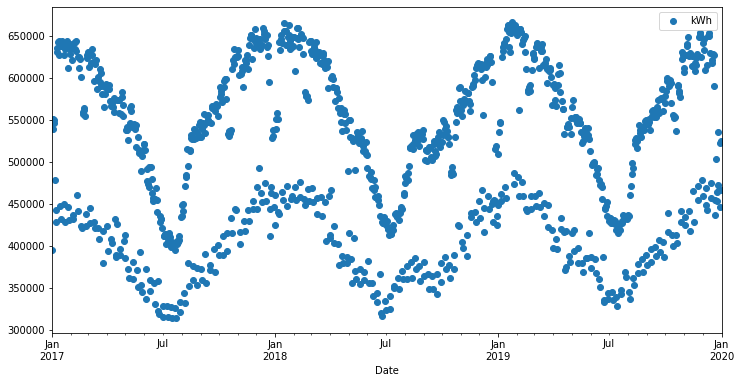

In [17]:
ts.plot(figsize = (12,6),style = 'o')

By having a first overview of the data, we can already recognize the notable yearly (seasonal) electricity demand pattern, with peaks during winter-spring then bottoms out in summer.

The two distinct layer along the horizontal axis is for the consumption during the weekday and weekend!! Energy consumption reduces during weekend!

#### visualization for each year

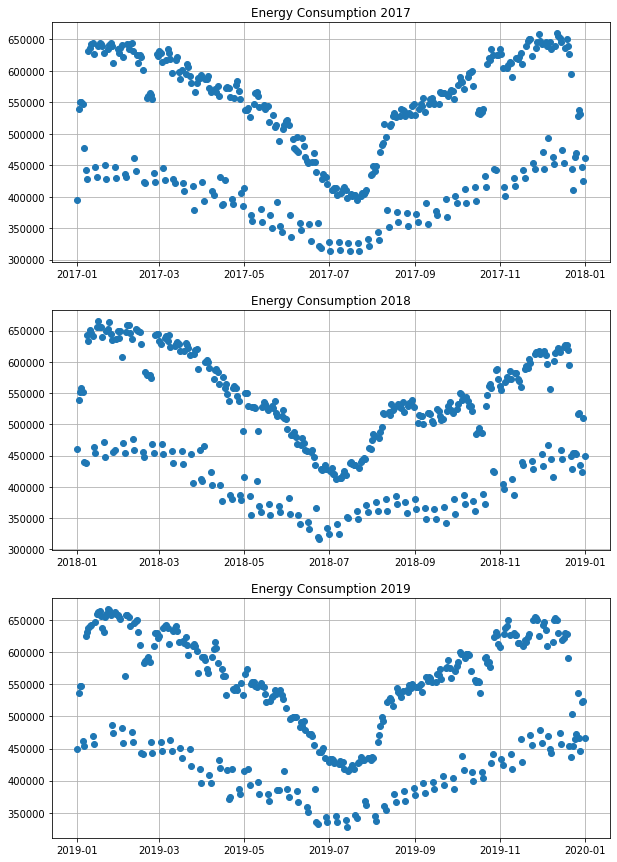

In [18]:
from matplotlib import pyplot as plt


ts2017,ts2018,ts2019 = ts['2017-01-01':'2018-01-01'],ts['2018-01-01':'2019-01-01'],ts['2019-01-01':'2020-01-01']
figs,ax =  plt.subplots(3,figsize=(10,15))


ax[0].plot(ts2017,'o')
ax[0].set_title('Energy Consumption 2017')
ax[0].grid(True)
ax[1].plot(ts2018,'o')
ax[1].set_title('Energy Consumption 2018')
ax[1].grid(True)
ax[2].plot(ts2019,'o')
ax[2].set_title('Energy Consumption 2019')
ax[2].grid(True)

plt.show()

The seasonality within each year is very much predictable. The demand peaks in winter-spring then bottoms out during summer.

#### Exploring the weekly seasonality pattern (within 2 month of data)

Text(0.5, 0.98, 'Energy Consumption in January 2017')

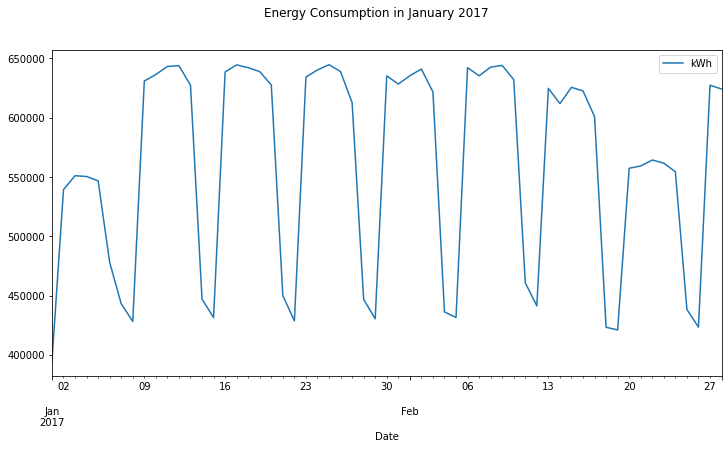

In [19]:
feb_end = '2017-02-28'

ts.loc[:feb_end].plot(figsize = (12,6))
plt.suptitle('Energy Consumption in January 2017')

Upon examining the plot, we can see that there is a very visible pattern that repeats itself every 7 days. Therefore, it can be deduced that there is a weekly seasonality within the time series. We can further explore this pattern by looking at the days of the weeks during the time period.



In [22]:
# The day of the week with Monday=0,..., Sunday=6
ts.loc[:feb_end].index.dayofweek

Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
            0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', name='Date')

From the result, we can see that energy consumption level is at its height during the weekdays, then drops significantly during the weekends. This very much fits our expectation, since factories and workplaces, which follow such a schedule, are places that consume the most energy.

# 3 Classical Decomposition Method (SARIMAX)



In the following section, we will further investigate the time series by decomposing it in to the 3 components:

Trend-cycle - increases or decreases within the data in the long-term or not of a fixed frequency.
Seasonal - pattern occurs when a time series is affected by seasonal factors.
Residuals - the remainder after removing the 2 aforementioned components.
If we are looking at an additive decomposition, this can be mathematically formulated as

$y_t = S_t + T_t + R_t$
,
where 
$y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the remainder component, all at period $t$.
t
. Similarly, a multiplicative decomposition would be written as

$y_t = S_t * T_t * R_t$

We first apply the classical decomposition method implemented in the class seasonal_decompose from the statsmodels package. For clarity, we only use a year of data.

#### 3-1 priliminary and advanced decomposition

In [23]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(10,9)
    plt.show()

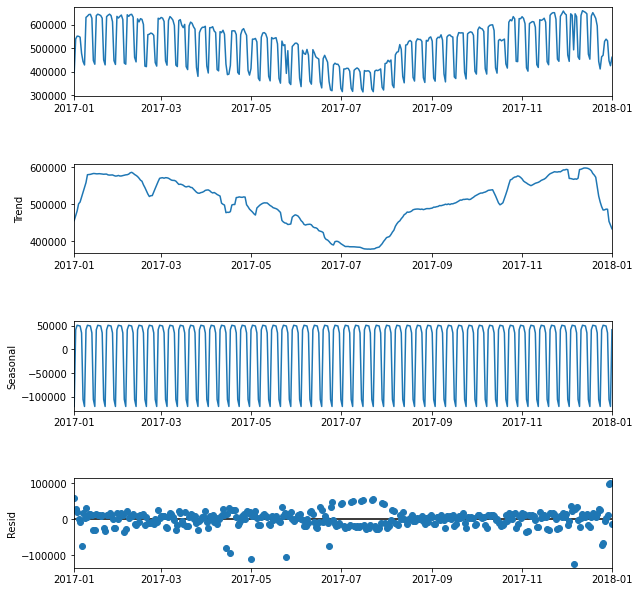

In [24]:
seasonal_decompose(ts2017)

Now, we can see the trends and the seasonality clearly. It seems that the trend show max consuption during Janurary, and less and less during the summer. The seasonality is mostly during week (weekdays more, and weekend less).

Concerning the residuals, it resembles white noise to some extent, thus indicating that the model is a good fit. However, it also exhibits some abnormalities with clear patterns, especially in the summer period. This suggests that the residuals also erroneously take into account of the trend component - a "leakage". The problem mostly stems from this method of decomposition itself, being a very old and outdated technique.

Fortunately, we can overcome this by substituting it for a novel, more sophisticated decomposition method called STL decomposition. The technique is implemented in the class STL in the same package.

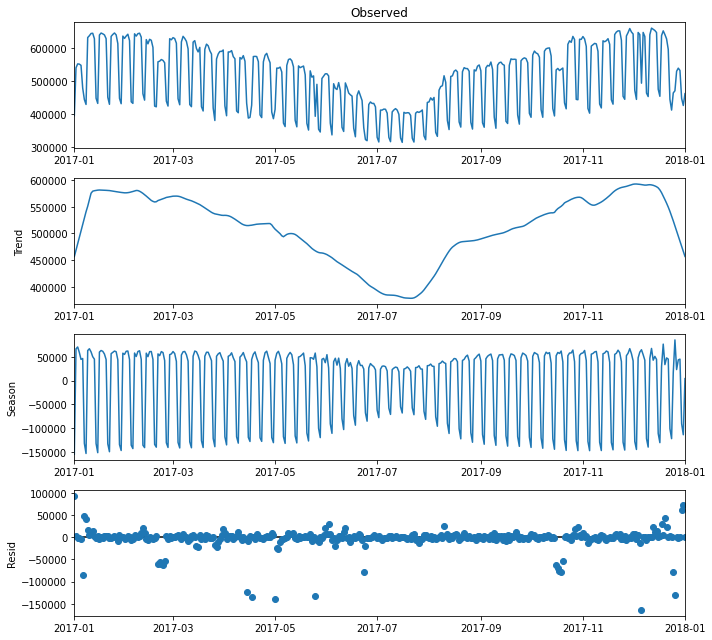

In [25]:
from statsmodels.tsa.seasonal import STL

plt.rcParams.update({'figure.figsize':(10,9)})

stl = STL(ts2017,seasonal=7,robust=True)
res = stl.fit()
fig = res.plot()

We can see that the quality of the decomposition is much better. That said, much of the patterns we have seen is still very much present. This means we have some detrending and deseasonalizing to do in the next step - modelling.

#### 3-2 test and train split

Keep the last month data (December 2020) for testing

<AxesSubplot:xlabel='Date'>

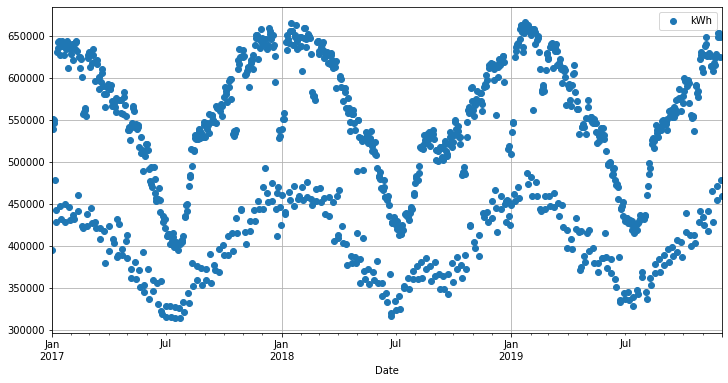

In [26]:
# split_point = int(len(y)*0.8) # 80% data for training

# y_to_train = y[:split_point] # dataset to train
# y_to_val = y[split_point:] # last X months for test  
# predict_date = len(y) - len(y[:split_point]) # the number of data points for the test set


demo = ts[demo_start:test_end]
train,test = ts[:train_end], ts[train_end:]

train.plot(figsize=(12,6), style = 'o',grid=True)

#### 3-3 Check for Stationarity

Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are (a) Visualization and (b) the Augmented Dickey-Fuller (ADF) Test. 


##### Method (a) Vidualization for stationarity

This method graphs the rolling statistics (mean and variance) to show at a glance whether the standard deviation changes substantially over time

In [27]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(y_timeseries, orig_data_title):
    
    #Determing rolling statistics
#     rolmean = pd.Series(y_timeseries).rolling(window=7).mean() 
#     rolstd = pd.Series(y_timeseries).rolling(window=7).std()
    rolmean = y_timeseries.iloc[:,0].rolling(window=7).mean() 
    rolstd = y_timeseries.iloc[:,0].rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y_timeseries, label= orig_data_title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

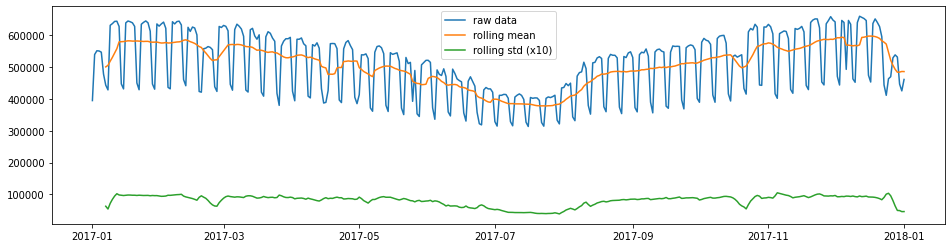

In [28]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(ts2017,'raw data')

For a time-series data to be stationary, it must have 3 conditinos: Expectation or Avergae over time should be zero, Variance over time (or std) should be constant, and also the auto-coreation should only depend on time lag not the time. We do not check the 3rd condition inthe graph above, but just the first two.

From picture above, we can confidently conclude that our data is not stationary since the E[y] is not zero, and it has an increasing trend.

If in some cases it is not clear that if it is stationary or not, we can use ADF test method.

##### Method (b) the Augmented Dickey-Fuller (ADF) Test

The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence.

In [29]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(y_timeseries, dataDescription):
    print(' > Is the {} stationary ?'.format(dataDescription))
    dftest = adfuller(y_timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: \t {:6.2f} -> The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [30]:
ADF_test(ts,'raw data')

 > Is the raw data stationary ?
Test statistic = -2.752
P-value = 0.066
Critical values :
	1%: 	  -3.44 -> The data is not stationary with 99% confidence
	5%: 	  -2.86 -> The data is not stationary with 95% confidence
	10%: 	  -2.57 -> The data is  stationary with 90% confidence


Looking at both the visualization and ADF test, we can tell that our original data is non-stationary. 

#### 3-4 Make the Data Stationary

To proceed with our time series analysis, we need to stationarize the dataset. There are many approaches to stationarize data, but we’ll use (a) de-trending, (b) differencing, and then (c) a combination of the two.

##### Method (a) Deterending:
This method removes the underlying trend in the time series:

 > Is the de-trended data stationary ?
Test statistic = -6.419
P-value = 0.000
Critical values :
	1%: 	  -3.44 -> The data is  stationary with 99% confidence
	5%: 	  -2.86 -> The data is  stationary with 95% confidence
	10%: 	  -2.57 -> The data is  stationary with 90% confidence


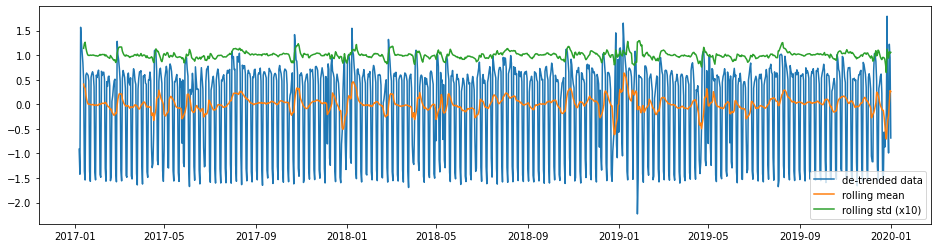

In [31]:
# Detrending
ts_detrend =  (ts - ts.rolling(window=7).mean())/ts.rolling(window=7).std()

test_stationarity(ts_detrend,'de-trended data')
ADF_test(ts_detrend,'de-trended data')

##### Method (b) Differencing:

Overall differencing is good way to remove both trend and seasonality. When seasonality presents in the data, the order of differencing shoud be selected as the time period of seasonality.

Since the sample dataset has a 7-day seasonality, I used a 7-lag difference:

 > Is the 7-days lag_ed differenced data stationary ?
Test statistic = -6.842
P-value = 0.000
Critical values :
	1%: 	  -3.44 -> The data is  stationary with 99% confidence
	5%: 	  -2.86 -> The data is  stationary with 95% confidence
	10%: 	  -2.57 -> The data is  stationary with 90% confidence


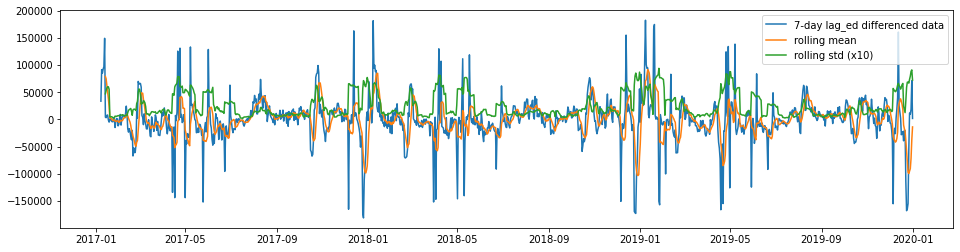

In [32]:
# Differencing
ts_7lag =  ts - ts.shift(7) # since we have DataFrame for every month at each row, shifting 12, means shifting 12 months

test_stationarity(ts_7lag,'7-day lag_ed differenced data')
ADF_test(ts_7lag,'7-days lag_ed differenced data')

In [33]:
# # invert differenced forecast
# def invert_diff(series, first_element_before):
#     cumsum = series.cumsum()
#     return cumsum.fillna(0) + first_element_original

# diffed = invert_diff(ts,seasonal_periods=7)
# diffed.plot(figsize=(10,6))

##### Methid (c): Combining Detrending and Differencing

 > Is the 7 lag differenced de-trended data stationary ?
Test statistic = -11.219
P-value = 0.000
Critical values :
	1%: 	  -3.44 -> The data is  stationary with 99% confidence
	5%: 	  -2.86 -> The data is  stationary with 95% confidence
	10%: 	  -2.57 -> The data is  stationary with 90% confidence


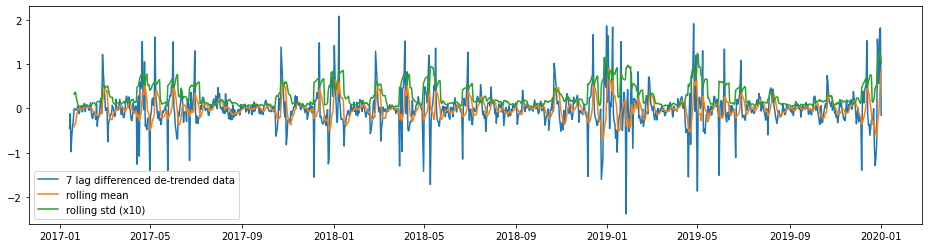

In [34]:
# Detrending + Differencing

ts_7lag_detrend =  ts_detrend - ts_detrend.shift(7)

test_stationarity(ts_7lag_detrend,'7 lag differenced de-trended data')
ADF_test(ts_7lag_detrend,'7 lag differenced de-trended data')

#### 3-5 AR versus MA for the stationary data

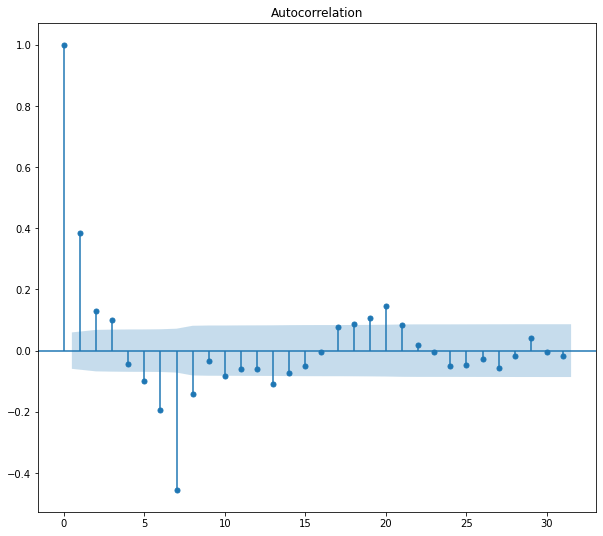

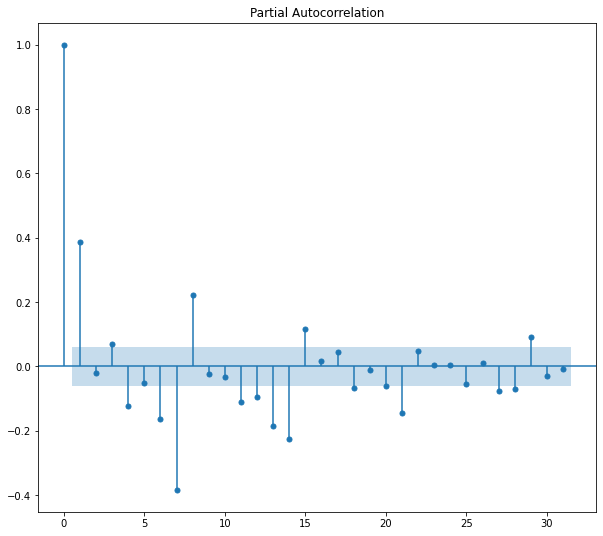

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf = plot_acf(ts_7lag_detrend.dropna())
pacf = plot_pacf(ts_7lag_detrend.dropna())

From the plots, a complex pattern with unexpected increases and decreases in the values of the functions can be found. Therefore, we cannot preclude any orders for the AR and MA terms.

With regards to the seasonal terms, the plots show expected behaviours with spikes at lags equals to the number of days in a week. It can be hypothesized that P = 1 and Q = 2, with the tapering autocorrelation function and the sinusoidal shape of the partial autocorrelation function. Let us check our guesses in the next section where we apply the model.

#### 3-6 holidays in Finland

For the exogenous/external variables, one prime candidate is the date of holidays in Finland. We can procure such data using the holidays package.



In [52]:
import holidays

begin = holiday_begin_date
abv = holiday_end_date
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:abv])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1

exo.drop(["kWh"],axis=1,inplace=True)
exo_train,exo_test = exo[:train_end],exo[train_end:abv]
exo_test[3:8]

,holidays
Date,
2019-12-04,0
2019-12-05,0
2019-12-06,1
2019-12-07,0
2019-12-08,0


#### 3-7 SARIMA

Suitable for time series data with trend and/or seasonal components

While exponential smoothing models use weighted averages of past observations to forecast new values, Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. In other words, ARIMA models look at differences between values in the time series. SARIMA builds upon the concept of ARIMA but extends it to model the seasonal elements in your data. 
 
You’ll notice that SARIMA includes several parameters that can be tuned to achieve optimal performance:
 
**Trend Elements**:

p: Trend autoregression order.

d: Trend difference order.

q: Trend moving average order.

**Seasonal Elements**:

P: Seasonal autoregressive order.

D: Seasonal difference order.

Q: Seasonal moving average order.

m: The number of time steps for a single seasonal period.

In order to get the best prediction, it’s important to find the values of SARIMA(p,d,q)(P,D,Q)m that optimize a metric of interest. We will just use a "grid search" to iteratively explore different combinations of parameters.

The evaluation metric we’ll use for the grid search is the **AIC (Akaike Information Criterion)** value. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. In general, we want to pick the combination with the lowest AIC value.

Help sources: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Additional codes can be added: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [53]:
import itertools

def sarima_grid_search(y, exo, pdq, seasonal_pdq):
    mini = float('+inf')

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                exog = exo,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
                    selcted_res = results

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    return selcted_res

In [55]:
seasonal_period = 7 # 7 days
p, d, q = range(0, 3), [1], range(0, 3)
pdq = list(itertools.product(p, d, q))
# print(pdq)

P,D,Q,s = range(0,3),[1],range(0,3),[7]
seasonal_pdq = list(itertools.product(P, D, Q, s))
# seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

selcted_result = sarima_grid_search(train, exo_train, pdq, seasonal_pdq)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 2)x(0, 1, 2, 7) - AIC:24083.48731679308


The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC, and we can see that SARIMA(1, 1, 2)x(0, 1, 2, 7) has the lowest AIC value. Since this method chose the best parameters, we will use this method to fit our model and compare the results with all the previous models discussed above.

#### 3-8 Model Validation

C:\Users\bahramih\Desktop\timeseries\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


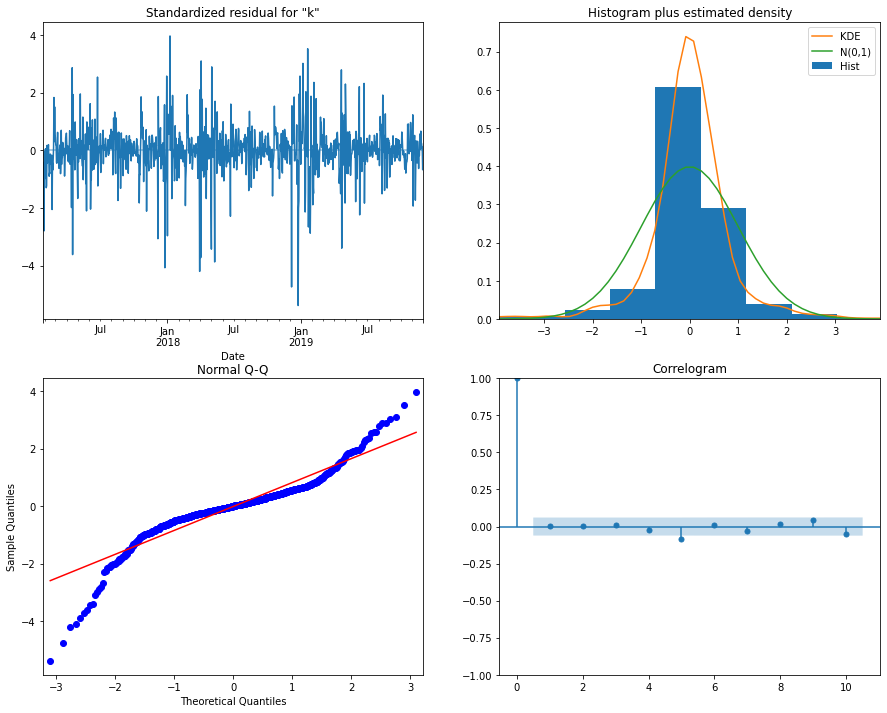

Ljung-box p-values:
[0.96469107 0.97876218 0.97158696 0.92827225 0.14043743 0.21107753
 0.2349744  0.29287039 0.23370604 0.14524578 0.12229839 0.08173682
 0.09481329 0.02669829]


C:\Users\bahramih\Desktop\timeseries\venv\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               kWh   No. Observations:                 1065
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 7)   Log Likelihood              -12034.744
Date:                           Tue, 27 Jul 2021   AIC                          24083.487
Time:                                   16:05:01   BIC                          24118.116
Sample:                               01-01-2017   HQIC                         24096.624
                                    - 12-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays   -6.651e+04   3103.244    -21.431      0.000   -7.26e+04   -6.04e+04
ar.L1         -0.1213      0.149     -0.815      0.415      -0.413       0.170
ma.L1         -0.2137      0.151     -1.411      0.158      -0.511       0.083
ma.L2         -0.2476      0.067     -3.709      0.000      -0.378      -0.117
ma.S.L7       -0.6579      0.028    -23.582      0.000      -0.713      -0.603
ma.S.L14       0.0614      0.027      2.254      0.024       0.008       0.115
sigma2      8.993e+08      0.007    1.3e+11      0.000    8.99e+08    8.99e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2242.97
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.75
Prob(H) (two-sided):                  0.09   Kurtosis:                        10.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.39e+27. Standard errors may be unstable.
"""

In [56]:
res = selcted_result
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

From the plots, the residuals seem to be normally distributed around 0 - which is the condition that we need - with slightly heavy tails. However, looking at the Ljung box statistics, we cannot reject the hypothesis that the data are not independently distributed, since the p-values are smaller than 
$α = 0.05$ for some lags from 6 onwards.

#### 3-9 Forecasting

In [57]:
import math
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

def sarima_forecast(result_obj, train_ts, test_ts, begining_date, pred_start_date, pred_end_date, demo_start, pred_exo, plot_whole_ts):
    results = result_obj
    
    pred_test = results.get_prediction(start=pred_start_date,end=pred_end_date,exog=pred_exo)
    err = 'Mean absolute percentage error: %.2f'% MAPE(test_ts, pred_test.predicted_mean) + \
    '\nRoot mean squared error: %.2f'% math.sqrt(MSE(test_ts, pred_test.predicted_mean))

        
    # Plotting part
    pred = results.get_prediction(start=begining_date, end=pred_end_date, exog=pred_exo, dynamic=False)
    pred_ci = pred.conf_int()

    fig, ax = plt.subplots(figsize=(12,7))
    ax.set(title='Energy consumption', ylabel='kWh')
    
    if plot_whole_ts:
        whole_ts = pd.concat([train,test[1:]], axis=0)
        whole_ts.plot(ax=ax, style = 'o')
        pred.predicted_mean.plot(ax=ax, style='o')
    else:
        train_ts[demo_start:].plot(ax=ax)
        test_ts.plot(ax=ax)
        pred.predicted_mean.plot(ax=ax)
        
    
    ci = pred_ci.loc[demo_start:]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
    legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
    
    if not plot_whole_ts:
        ax.grid(True)


In [39]:
# list(y.index)[split_point]

C:\Users\bahramih\Desktop\timeseries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\bahramih\Desktop\timeseries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


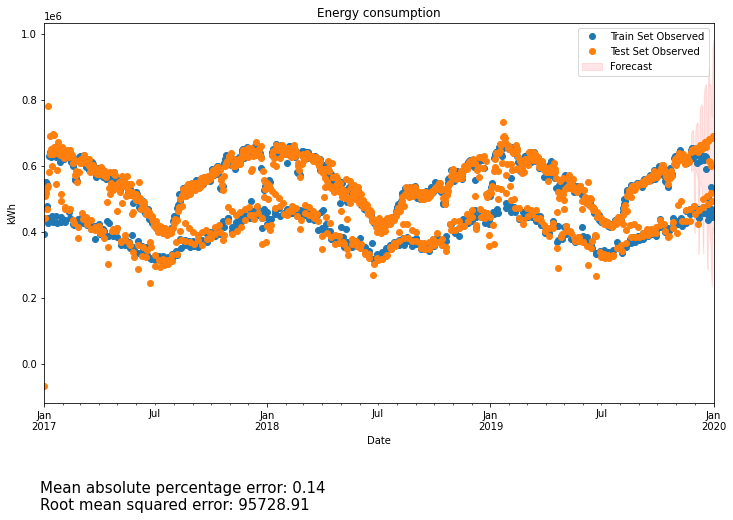

In [58]:
sarima_forecast(selcted_result, train, test, begin, train_end, test_end, demo_start, exo_test, plot_whole_ts=True)

C:\Users\bahramih\Desktop\timeseries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\bahramih\Desktop\timeseries\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


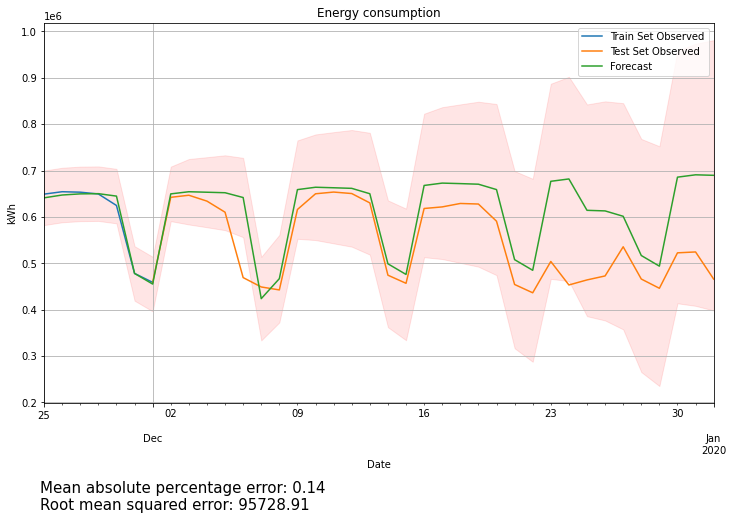

In [59]:
# send the start date for the plot prediction as demo_date

sarima_forecast(selcted_result, train, test, demo_start, train_end, test_end, demo_start, exo_test, plot_whole_ts=False)

The result looks very satisfactory! During the first 2 weeks of the month (December), the forecasted values fit well to the actual ones, possibly with the exception of the 6th of December - the Independence day of Finland.

With regards to the winter holiday season, the model unfortunately did not do as well. Contrary to the first 2 weeks, the only day where the values are more accurately predicted is the 27th, despite the addition of the "holiday" variable. This shows the challenges of forecasting during exceptional time periods. Nevertheless, the model still show promises in forecasting when the data behaves predictably.

# 4 LSTM method

https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data

In [60]:
import torch
import torch
import torch.nn as nn
from torch.autograd import Variable

from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset

from torch.autograd import Variable


#### 4-1 Feature Engineering

We want to convert our original time series to something that is more informative. There are two steps:

    (a) Adding the holidays as a separate columns for LSTM . Previously we used to pass exo_test dataframe into our SARIMAX packages.
    
    (b) The x-variable is basically the datatimes (dates, YY-MM-DD). This is not very useful for LSTM. One apprach is to have a column as x that basically starts from 0 all the way to the end (incereents by 1 for each day). Then, we use sin(X) and cos(X) to represent the cylic behavior of x in the presentation. At the end each x (each row) will be respresented at a point in the circle. The cyclic points will be on the same place i nthis circle.
    
    https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
    

#### Holiday column (holiday feature eng)

In [64]:
import holidays

begin = holiday_begin_date
abv = holiday_end_date

hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:abv])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts.head()

,kWh,holidays
Date,,
2017-01-01,394640.91000000,1
2017-01-02,539286.52000000,0
2017-01-03,551064.86000000,0
2017-01-04,550431.90000000,0
2017-01-05,546732.54000000,0


#### Cyclical feature encoding
The separate datetime data on its own is not very useful to the learning task. Therefore, we need a way to encode the periodicity of the time series from our knowledge into the data. This can be achieved by modelling time as a circular scale, which is simply mapping the date time values using trigonometric functions.

In [65]:
date = ts.index
timestamp_in_second = date.map(datetime.timestamp)
timestamp_in_second

Float64Index([1483246800.0, 1483333200.0, 1483419600.0, 1483506000.0,
              1483592400.0, 1483678800.0, 1483765200.0, 1483851600.0,
              1483938000.0, 1484024400.0,
              ...
              1577077200.0, 1577163600.0, 1577250000.0, 1577336400.0,
              1577422800.0, 1577509200.0, 1577595600.0, 1577682000.0,
              1577768400.0, 1577854800.0],
             dtype='float64', name='Date', length=1096)

Text(0.5, 1.0, 'Time of week signal')

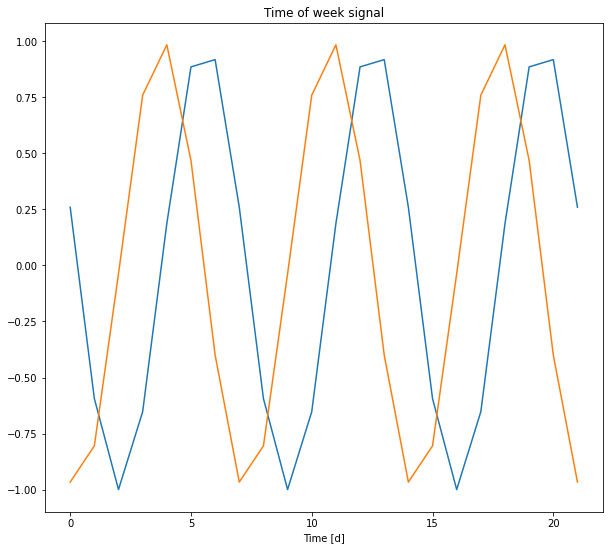

In [66]:
num_of_sec_in_a_week = 7*24*60*60

week = num_of_sec_in_a_week
ts['Week sin'] = np.sin(timestamp_in_second * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_in_second * (2 * np.pi / week))

plt.plot(np.array(ts['Week sin'])[:22])
plt.plot(np.array(ts['Week cos'])[:22])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [67]:
ts.head(3)

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,394640.91000000,1,0.25881905,-0.96592583
2017-01-02,539286.52000000,0,-0.59382019,-0.80459778
2017-01-03,551064.86000000,0,-0.99930070,-0.03739119


In [68]:
ts.describe()

,kWh,holidays,Week sin,Week cos
count,1096.00000000,1096.00000000,1096.00000000,1096.00000000
mean,510057.96580839,0.02828467,-0.00181258,-0.00095798
std,95115.99654918,0.16586063,0.70732636,0.70752982
min,313289.11000000,0.00000000,-0.99930070,-0.96592583
25%,430323.90500000,0.00000000,-0.65228741,-0.80459778
50%,524594.26100000,0.00000000,0.14904227,-0.07473009
75%,592114.02200000,0.00000000,0.86602540,0.73305187
max,667142.98062500,1.00000000,0.93087375,0.98883083


#### 4-2 normialization

Since there are big discrepancies between the scales of the different features, we need to normalize them into a common scale, without distorting the differences in the ranges of values or losing information.

In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
ts_normalized = pd.DataFrame(scaler.fit_transform(ts),
                             columns = ts.columns.values,
                            index = ts.index)
# scaling and fit only for "kWh" column
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts[["kWh"]])


In [70]:
ts_normalized.head(4)

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.22990225,1.00000000,0.65181660,0.00000000
2017-01-02,0.63867440,0.00000000,0.21007454,0.08253101
2017-01-03,0.67196029,0.00000000,0.00000000,0.47501290
2017-01-04,0.67017153,0.00000000,0.17978338,0.88189880


#### plot for normalized ts data

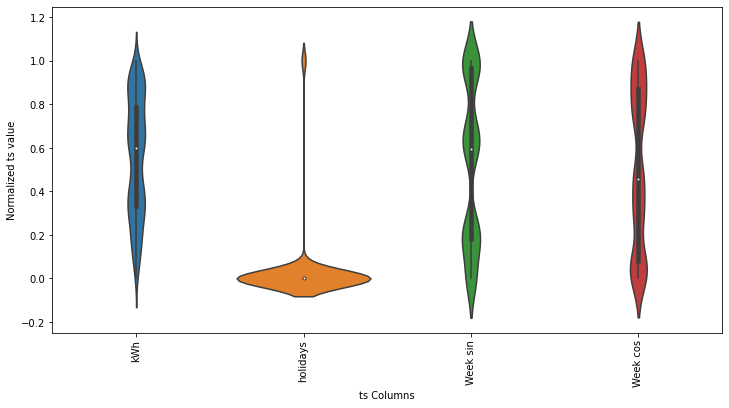

In [74]:
import seaborn as sns

melt_plot = ts_normalized.melt(var_name='ts Columns', value_name='Normalized ts value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='ts Columns', y='Normalized ts value', data=melt_plot)
_ = ax.set_xticklabels(ts_normalized.keys(), rotation=90)


#### 4-3 Modeling

#### test and train dataset

In [76]:
test_df = ts_normalized[train_end:]
train_val = ts_normalized[:train_end]

n = len(train_val)

# 80% to traning and rest for test dataset
train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.22990225,1.00000000,0.65181660,0.00000000
2017-01-02,0.63867440,0.00000000,0.21007454,0.08253101
2017-01-03,0.67196029,0.00000000,0.00000000,0.47501290
2017-01-04,0.67017153,0.00000000,0.17978338,0.88189880
2017-01-05,0.65971705,0.00000000,0.61404414,0.99679533
...,...,...,...,...
2019-04-28,0.18856658,0.00000000,0.67043467,0.00529632
2019-04-29,0.67599203,0.00000000,0.22587629,0.07146007
2019-04-30,0.62261067,0.00000000,0.00108638,0.45591134


#### split the sequences in ts into split of 4-weeks

In order for the LSTM to work, we need to create sliding windows from the data so that for each datapoint, its features is the window of a determined size of the past values . In this project, the width of the features vector is 28 days, or 4 weeks, while there is only one label for each window.

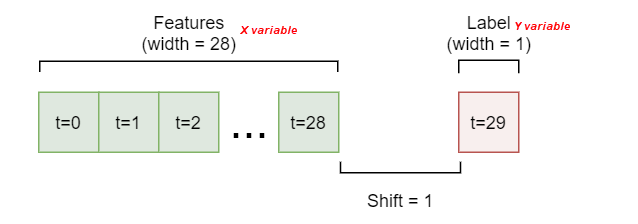



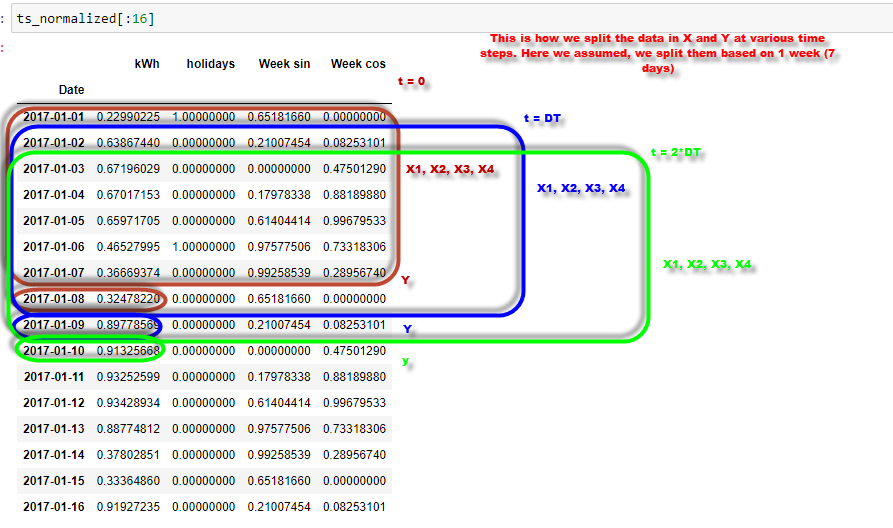

In [77]:
def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0]):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list(int)): list of the columns for the labels.
            ra
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of labels
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
    print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
          .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels

    
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [96]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_ts,y_ts = split_sequence(ts_normalized, fea_width, label_width, shift, label_col_indices)

X_train,y_train = split_sequence(train_df, fea_width, label_width, shift, label_col_indices)

X_val,y_val = split_sequence(val_df, fea_width, label_width, shift, label_col_indices)

X_test,y_test = split_sequence(test_df, fea_width, label_width, shift, label_col_indices)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 4), (1,))

#### data into Pytorch tensors

In [107]:

def to_tensor(ls):
    # ls is in dataframe. COnvert it to numpy, then to pytprch tensor
    # if cuda is avilable, or wants to be run in Google Colab
#     return Variable(torch.cuda.FloatTensor(np.array(ls)))
    return Variable(torch.FloatTensor(np.array(ls)))


X_ts,y_ts = to_tensor(X_ts),to_tensor(y_ts)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

tensor([[[2.2990e-01, 1.0000e+00, 6.5182e-01, 2.1805e-13],
         [6.3867e-01, 0.0000e+00, 2.1007e-01, 8.2531e-02],
         [6.7196e-01, 0.0000e+00, 3.3529e-14, 4.7501e-01],
         ...,
         [9.2014e-01, 0.0000e+00, 6.1404e-01, 9.9680e-01],
         [8.4597e-01, 0.0000e+00, 9.7578e-01, 7.3318e-01],
         [3.7709e-01, 0.0000e+00, 9.9259e-01, 2.8957e-01]],

        [[6.3867e-01, 0.0000e+00, 2.1007e-01, 8.2531e-02],
         [6.7196e-01, 0.0000e+00, 3.3529e-14, 4.7501e-01],
         [6.7017e-01, 0.0000e+00, 1.7978e-01, 8.8190e-01],
         ...,
         [8.4597e-01, 0.0000e+00, 9.7578e-01, 7.3318e-01],
         [3.7709e-01, 0.0000e+00, 9.9259e-01, 2.8957e-01],
         [3.3102e-01, 0.0000e+00, 6.5182e-01, 1.0902e-13]],

        [[6.7196e-01, 0.0000e+00, 3.3529e-14, 4.7501e-01],
         [6.7017e-01, 0.0000e+00, 1.7978e-01, 8.8190e-01],
         [6.5972e-01, 0.0000e+00, 6.1404e-01, 9.9680e-01],
         ...,
         [3.7709e-01, 0.0000e+00, 9.9259e-01, 2.8957e-01],
         [

#### LSTM model

1) We now can finally get to building the neural network! Our model has 2 hidden LSTM layers with 512 neurons each. Since our X has four columns, the input layer will have 4 neurons, and since it is one class, the output layer has just one neuron. 

2) The Adam optimizer is used, and the learning rate is dynamically modified using a scheduler.

3) The LSTM library from pytorch is directly being used

4) in an LSTM unit (x, c, h) are input and (y, c, h) are output (Google a LSTM modul)

The architecture is inspired by OmerS. 

https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data


In [108]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, cuda_device=True):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        if cuda_device:
            h_1 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size).cuda())


            c_1 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size).cuda())
        else:
            h_1 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size))


            c_1 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size))        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out



Some initialization, and building the LSTM model object, before starting looping over epocs

In [109]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 300
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

cuda_device = False
model = LSTM(num_classes, input_size, hidden_size, num_layers, cuda_device)

if cuda_device:
    model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [110]:
for epoch in progress_bar(range(1,num_epochs+1)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    if epoch%20 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

Epoch: 1, loss: 0.67866 validation loss:  0.26688 
Epoch: 21, loss: 0.17593 validation loss:  0.15255 
Epoch: 41, loss: 0.14150 validation loss:  0.12356 
Epoch: 61, loss: 0.12841 validation loss:  0.11057 
Epoch: 81, loss: 0.09194 validation loss:  0.06012 
Epoch: 101, loss: 0.08426 validation loss:  0.05374 
Epoch: 121, loss: 0.07958 validation loss:  0.04867 
Epoch: 141, loss: 0.07991 validation loss:  0.04594 
Epoch: 161, loss: 0.07518 validation loss:  0.04383 
Epoch: 181, loss: 0.07779 validation loss:  0.04726 
Epoch: 201, loss: 0.07352 validation loss:  0.04273 
Epoch: 221, loss: 0.06965 validation loss:  0.04210 
Epoch: 241, loss: 0.06809 validation loss:  0.04229 
Epoch: 261, loss: 0.06586 validation loss:  0.04005 
Epoch: 281, loss: 0.06673 validation loss:  0.04333 
Final: 
Epoch: 300, loss: 0.06562 validation loss:  0.04184 


#### Model Evaluation

So far, so good. Now we need to check the error of the model on the test set without normalization.

In [111]:
model.eval()

 
y_test_pred_normalized = model(X_test).cpu().detach().numpy()
y_test_pred = scaler_kwh.inverse_transform(y_test_pred_normalized)   ## Inverse Normalize

y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(MSE(y_test_obs,y_test_pred)),2)) +
      '\nThe root mean squared error of the model is ' + 
     str(round(MAPE(y_test_obs,y_test_pred),2)))

The root mean squared error of the model is 57570.56
The root mean squared error of the model is 0.1


This is only a marginal improvement over the SARIMAX model. In fact, we can see that the LSTM model performs worse than the classical method after accounting for the far greater level of complexity of the Deep Neural Networks. This is in agreement with the literature on time series forecasting, with deep learning methods having not delivered on their promises.

#### Forecast graph for the whole dataset (no test/train distiction)

Text(0, 0.5, 'kWh')

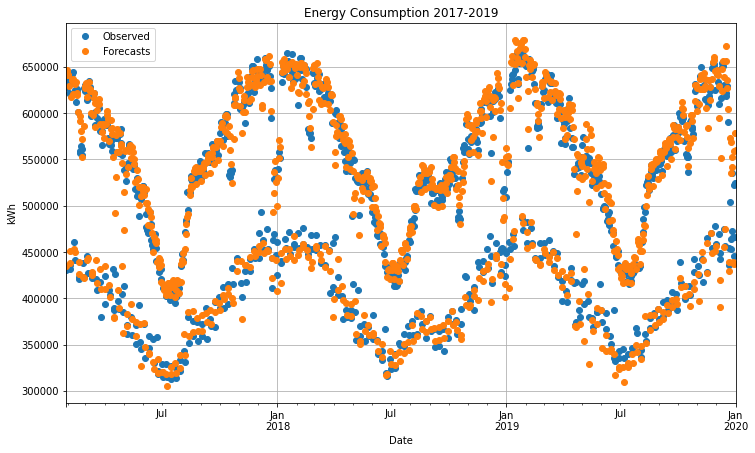

In [112]:
y_pred = scaler_kwh.inverse_transform(model(X_ts).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts.cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df,pred_df],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = 'o', grid=True)
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")

The forecasts appear to fit the observed values well, but is worse than that of the SARIMA with consistent under-prediction of the max values. Let us look at the prediction on the test set compare it with that of the SARIMAX.



Text(0, 0.5, 'kWh')

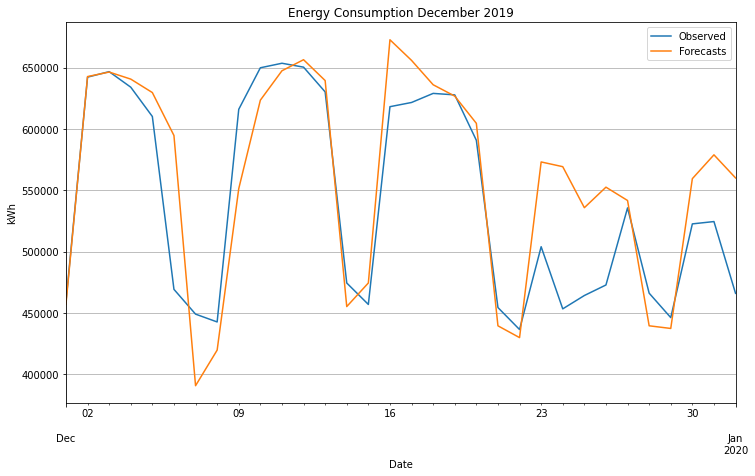

In [113]:
fig, ax = plt.subplots()
plot_df.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)

ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption December 2019")
ax.set_ylabel("kWh")